Part 1: Importing the standard Data Science stack

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame


Part 2: Importing dataset from google drive and dropping unnecessary features. Filling in any null values with the mean of the column.

In [ ]:
#Cleaning dataset
from google.colab import drive
from sklearn.model_selection import train_test_split
from copy import deepcopy

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/MidtermProject/

#Importing data, dropping unnecessary columns
data = DataFrame(pd.read_csv('male_players_15.csv'))
drops = [c for c in data.columns if c not in['value_eur','defending','shooting','passing','dribbling','physic']]
data = data.drop(columns=drops)

#filling null values
for c in data:
  data[c].fillna(data[c].mean(), inplace=True)

#seperating independent variable and result dataframes
result = data['value_eur']
data = data.drop(columns=['value_eur'])

#creating a deepcopy of unnormalized data in order to unnormalize our output after prediction
result_unnorm = deepcopy(result)
data_unnorm = deepcopy(data)

#normalizing independent variables
for d in data:
  data[d] = (data[d]-min(data[d]))/(max(data[d])-min(data[d]))

#converting to numpy arrays
Y = result.to_numpy()
X = data.to_numpy()

#normalizing dependent variable
Y = (Y-min(Y))/(max(Y)-min(Y))

#test train split
trainX,testX,trainY,testY = train_test_split(X,Y,test_size=0.3, random_state=3)

data.head


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/MidtermProject


<ipython-input-22-e037c12635f9>:11: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  data = DataFrame(pd.read_csv('male_players_15.csv'))


<bound method NDFrame.head of        shooting   passing  dribbling  defending    physic
0      0.943662  0.925373   1.000000   0.086957  0.555556
1      1.000000  0.850746   0.929577   0.159420  0.809524
2      0.901408  0.880597   0.943662   0.159420  0.571429
3      0.971831  0.850746   0.859155   0.188406  0.920635
4      0.416653  0.472219   0.500361   0.418792  0.579966
...         ...       ...        ...        ...       ...
16150  0.042254  0.074627   0.070423   0.260870  0.396825
16151  0.267606  0.044776   0.140845   0.086957  0.206349
16152  0.197183  0.268657   0.281690   0.144928  0.079365
16153  0.070423  0.164179   0.084507   0.449275  0.634921
16154  0.070423  0.044776   0.070423   0.202899  0.523810

[16155 rows x 5 columns]>

Part 3: Graphing all independent variables seperately with dependent variable (value in 100 million euros).

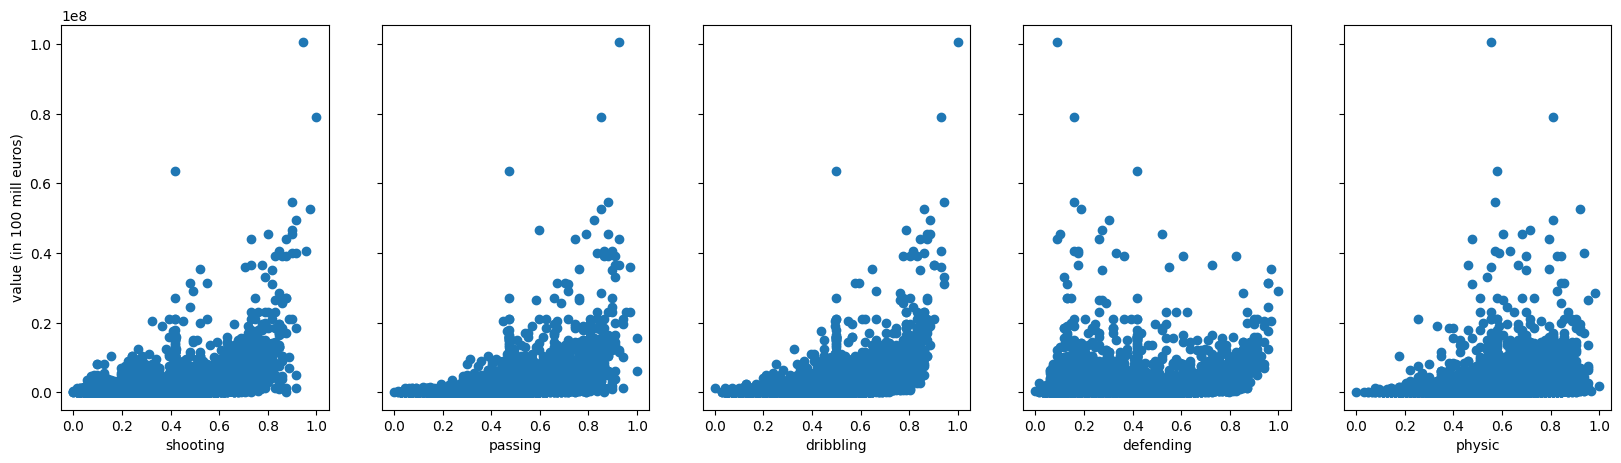

In [ ]:
#Graphs for each var using subplots
fig, ax = plt.subplots(1,len(data.columns),sharey = True, figsize=(20,5))

for i, d in enumerate(data):
  ax[i].scatter(data[d],result)
  ax[0].set_ylabel('value (in 100 mill euros)')
  ax[i].set_xlabel(d)

plt.show()

Part 4: Fitting a polynomial model to each of the graphs in order to see which variables are easiest to predict. Using the result from this we decided to replace one of our original independent variables (PACE) with a new one (DEFENDING).


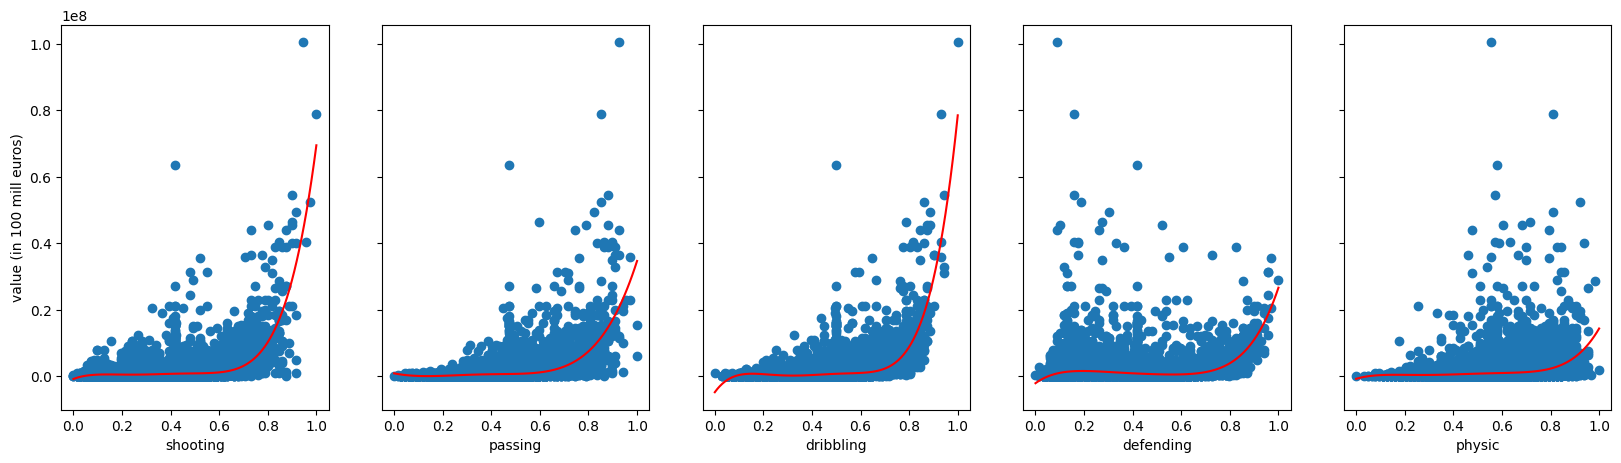

In [ ]:
#Poly regression for each var

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import preprocessing
import numpy as np

#Setting up subplots
fig, ax = plt.subplots(1,len(data.columns),sharey = True, figsize=(20,5))


#Loop through each independent variable
for i, d in enumerate(data):
  #Getting polynomial features for each independent variable
  poly = PolynomialFeatures(degree=5)
  X_poly = poly.fit_transform(np.array(data[d]).reshape(-1,1))

  #Using polynomial features to make a linear model
  model = LinearRegression()
  model.fit(X_poly, result)

  #Making a linspace x, and then predicting yhat for it using the linear model. We will graph x and y to see the curve on our graph
  x=np.linspace(0,1,100)
  new_poly = poly.transform(x.reshape(-1,1))
  pred = model.predict(new_poly)

  #Plotting
  ax[i].plot(x,pred,color='red')
  ax[i].scatter(data[d],result)
  ax[0].set_ylabel('value (in 100 mill euros)')
  ax[i].set_xlabel(d)

plt.show()


Part 5: Try fitting polynomial models of various degrees to the data. Store the r^2 scores for each model, and the degree with the highest score (degree 5) will be the one we use when predicting.



Delta r^2 for each run

1 0.0382616772313098
2 0.027014167207286444
3 -0.021731475322601113
4 -0.0692549704872849
5 -0.07661755426198213
6 -0.027751697486128046
7 0.0825497626540388
8 0.4592952309991437


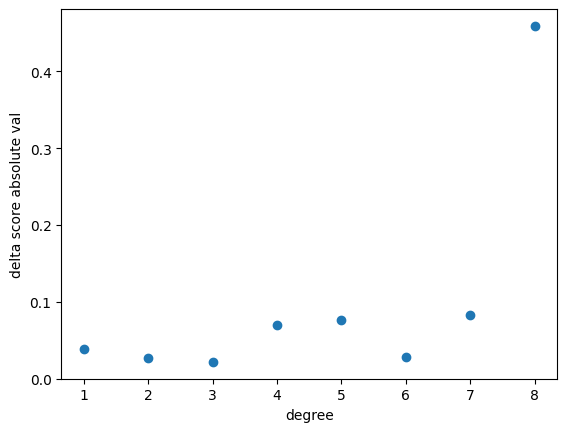


Best r^2 score

0.8370347648322372 5


In [ ]:
#TODO Implement Multivariate Polynomial Regression
#link https://saturncloud.io/blog/multivariate-polynomial-regression-with-python/#:~:text=What%20is%20Multivariate%20Polynomial%20Regression,variables%20and%20the%20target%20variable.
from sklearn.metrics import r2_score

#Storing r2 scores and degrees
r2_arr = []
deg_arr = []
delta = []

#Does polynomial regression and returns r2 score between prediction and test y for degree n
def poly_r(n):
  poly = PolynomialFeatures(degree=n)
  X_poly = poly.fit_transform(trainX)

  model = LinearRegression()
  model.fit(X_poly, trainY)

  pred_l = []

  new_poly = poly.transform(testX)
  pred = model.predict(new_poly)

  tr_poly = poly.transform(trainX)
  tr_pred = model.predict(tr_poly)

  return r2_score(testY,pred), r2_score(trainY,tr_pred)-r2_score(testY,pred), model.intercept_, model.coef_


for i in range(1,9):
  score, d = poly_r(i)[0:2]
  r2_arr.append(score)
  delta.append(d)
  deg_arr.append(i)

max_sc = max(r2_arr)
ind  = r2_arr.index(max_sc)
n = deg_arr[ind]

#delta = [abs(i) for i in delta]

print("\nDelta r^2 for each run\n")
for i, d in enumerate(delta):
  delta[i] = abs(d)
  print(i+1, d)



plt.scatter(np.arange(1,9),delta)
plt.xlabel('degree')
plt.ylabel('delta score absolute val')
plt.show()

print("\nBest r^2 score\n")
print(max_sc,ind+1)

#^^ This code used to find the best degree, which is 5

Part 6: Take independent variables inputted by the user, then use a degree 5 polynomial model to predict with those variables. Return the formatted output to the user.

In [ ]:
#make and fit model
model = LinearRegression()
model.fit(X_poly, trainY)

#Used to normalize input features
def normalize(features):
  ret = []
  for i, d in enumerate(['shooting','passing','dribbling','defending','physic']):
    ret.append((features[i]-min(data_unnorm[d]))/(max(data_unnorm[d])-min(data_unnorm[d])))
  return np.array(ret)

#Used to unnormalize the output when we are done predicting and want to return the output to the user
def unnormalize(pred):
  return pred*(max(result_unnorm) - min(result_unnorm))+min(result_unnorm)

def predict(features):
  #normalize features
  features = normalize(features)
  #get poly features
  poly = PolynomialFeatures(degree=5)
  X_poly = poly.fit_transform(trainX)

  #return a rounded and unnormalized prediction
  return round(unnormalize(model.predict(poly.transform(features.reshape(1,-1)))[0]),2)

#Collect input
inp = []

inp.append(int(input("What is your player's DEFENDING rating?: ")))
inp.append(int(input("What is your player's SHOOTING rating?: ")))
inp.append(int(input("What is your player's PASSING rating?: ")))
inp.append(int(input("What is your player's DRIBBLING rating?: ")))
inp.append(int(input("What is your player's PHYSIC rating?: ")))

#Get the prediction
ans = str(predict(inp))

#If the prediction is less than 0 (the result of extrapolation) then just say the player is valued at 0
if float(ans) < 0:
  print('Your player is valued €0')
else:
  #Formatting the string
  dec = ans[-3:]
  ans = ans[:-3]

  i = len(ans)-3

  while i>=0:
    ans = ans[:i]+','+ans[i:]
    i-=3

  if ans[:1] == ',':
    ans = ans[1:]

  #Returning the answer
  print('Your player is valued €'+ans+dec)

ValueError: ignored